In [1]:
from sqlalchemy import create_engine
import pandas as pd

# Define your database connection parameters
host="localhost"
port=3306
user="root"
password="Afu27959"
database="thesisCurrent"
database2="thesisv6.9"

# Create a SQLAlchemy engine
engine1 = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

engine2 = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database2}')

# Query to get data
query1 = """
SELECT uniprot, tdl FROM protein JOIN target ON protein.ID = target.ID;
"""
df1 = pd.read_sql(query1, engine1) #Current
#print(df1)

query2 = """
SELECT uniprot, tdl FROM protein JOIN target ON protein.ID = target.ID;
"""
df2 = pd.read_sql(query2, engine2) #Older

def compare_versions(df1, df2):
    # Merge dataframes on 'uniprot'
    merged = df1.rename(columns={'tdl': 'TDL_current'}).merge(
        df2.rename(columns={'tdl': 'TDL_v6_9'}),
        on='uniprot',
        how='outer'
    )
    
    # Find proteins that were Tdark in v6.9 and reclassified in v6.11
    reclassified = merged[(merged['TDL_v6_9'] == 'Tdark') & (merged['TDL_current'] != 'Tdark')]
    
    return reclassified

# Compare versions
reclassified_proteins = compare_versions(df1, df2)

uniprot_list = reclassified_proteins['uniprot'].tolist()
formatted_uniprot_list = "', '".join(uniprot_list)
print(len(uniprot_list))

# Query to get family information from idg_evol table
query_fam = f"""
SELECT DISTINCT uniprot, fam
FROM idg_evol
WHERE uniprot IN ('{formatted_uniprot_list}');
"""

# Fetch the family data from the database
fam_df = pd.read_sql(query_fam, engine1)

# Merge the family data with the reclassified proteins dataframe
reclassified_proteins_with_fam = reclassified_proteins.merge(fam_df, on='uniprot', how='left')

# Display results with the added family column
print(reclassified_proteins_with_fam)
print(f"Number of reclassified proteins: {len(reclassified_proteins_with_fam)}")


1785
     uniprot TDL_current TDL_v6_9  fam
0     A0AV96        Tbio    Tdark  NaN
1     A0AVF1        Tbio    Tdark  NaN
2     A0FGR9        Tbio    Tdark  NaN
3     A0JNW5        Tbio    Tdark  NaN
4     A0PJK1        Tbio    Tdark  NaN
...      ...         ...      ...  ...
1780  Q9Y6I8        Tbio    Tdark  NaN
1781  Q9Y6I9        Tbio    Tdark  NaN
1782  Q9Y6L7       Tchem    Tdark  NaN
1783  Q9Y6Q3        Tbio    Tdark  NaN
1784  Q9Y6V7        Tbio    Tdark  NaN

[1785 rows x 4 columns]
Number of reclassified proteins: 1785


In [2]:
if uniprot_list:
    # Format the list for SQL query
    formatted_uniprot_list = "', '".join(uniprot_list)
    
    # SQL query to get relevant data from the database
    query_data1 = f"""
    SELECT 
        p.uniprot AS uniprot,
        p.seq AS sequence,
        da.smiles AS smiles,
        da.act_value AS affinity
    FROM 
        protein p
    JOIN 
        drug_activity da ON p.id = da.target_id
    WHERE 
        p.uniprot IN ('{formatted_uniprot_list}')
    UNION ALL

    SELECT 
        p.uniprot AS uniprot,
        p.seq AS sequence,
        ca.smiles AS smiles,
        ca.act_value AS affinity
    FROM 
        protein p
    JOIN 
        target t ON p.id = t.id
    JOIN 
        cmpd_activity ca ON t.id = ca.target_id
    WHERE 
        p.uniprot IN ('{formatted_uniprot_list}')
    """

###  GETTING RESULTS NOT IN RECLASSIFIED SET 

In [3]:
if uniprot_list:
    # Format the list for SQL query
    formatted_uniprot_list = "', '".join(uniprot_list)
    
    # SQL query to get relevant data from the database
    query_data2 = f"""
    SELECT 
        p.seq AS sequence,
        da.smiles AS smiles,
        da.act_value AS affinity
    FROM 
        protein p
    JOIN 
        drug_activity da ON p.id = da.target_id
    WHERE 
        p.seq IS NOT NULL AND p.seq <> '' 
        AND da.smiles IS NOT NULL AND da.smiles <> '' 
        AND da.act_value IS NOT NULL
        AND p.uniprot NOT IN ('{formatted_uniprot_list}')

    UNION ALL

    SELECT 
        p.seq AS sequence,
        ca.smiles AS smiles,
        ca.act_value AS affinity
    FROM 
        protein p
    JOIN 
        target t ON p.id = t.id
    JOIN 
        cmpd_activity ca ON t.id = ca.target_id
    WHERE 
        p.seq IS NOT NULL AND p.seq <> '' 
        AND ca.smiles IS NOT NULL AND ca.smiles <> '' 
        AND ca.act_value IS NOT NULL
        AND p.uniprot NOT IN ('{formatted_uniprot_list}');
    """

In [4]:
df_val = pd.read_sql(query_data2, engine1)
df_val = df_val.rename(columns={
    'smiles': 'compound_iso_smiles',
    'sequence': 'target_sequence'
})
data_df = df_val[['compound_iso_smiles', 'target_sequence', 'affinity']]
print(data_df.columns)

missing_values = data_df.isna().sum()
empty_strings = (data_df == "").sum()

print("Missing values per column:\n", missing_values)
print("Empty string counts per column:\n", empty_strings)

data_df = data_df.replace("", pd.NA).dropna()
print("Number of rows in df", len(data_df))

#remove smiles that was throwing error (1 record)
data_df = data_df[data_df['compound_iso_smiles'] != '[H+].C1=CC(=C(C=C1CCC(=O)NCCCCCC(=O)NCCCC[C@@H](C(=O)O)NC(=O)N[C@@H](CCC(=O)O)C(=O)O)CN(CCN(CC2=C(C=CC(=C2)CCC(=O)O)[O-])CC(=O)[O-])CC(=O)[O-])[O-].[68Ga+3]']

from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import warnings
# **Validate SMILES strings using RDKit**
# Function to validate SMILES and check for specific warnings
def is_valid_smiles(smile):
    return Chem.MolFromSmiles(smile) is not None

# Apply validation
valid_smiles_mask = data_df['compound_iso_smiles'].apply(is_valid_smiles)

# Count invalid SMILES
num_invalid_smiles = (~valid_smiles_mask).sum()
print(f"Number of invalid SMILES: {num_invalid_smiles}")

# Keep only valid rows
data_df = data_df[valid_smiles_mask]

print("Number of valid rows in df:", len(data_df))

Index(['compound_iso_smiles', 'target_sequence', 'affinity'], dtype='object')
Missing values per column:
 compound_iso_smiles    0
target_sequence        0
affinity               0
dtype: int64
Empty string counts per column:
 compound_iso_smiles    0
target_sequence        0
affinity               0
dtype: int64
Number of rows in df 643065


[17:30:09] Explicit valence for atom # 8 C, 5, is greater than permitted
[17:30:09] Explicit valence for atom # 8 C, 5, is greater than permitted
[17:30:09] Explicit valence for atom # 1 N, 4, is greater than permitted


Number of invalid SMILES: 3
Number of valid rows in df: 643061


***Creating pharos.csv***

In [5]:
data_df.to_csv('pharos_full.csv', index=False)


Trying to get pt files

In [2]:
import sys
# Add the project directory to the Python path
sys.path.append('/Users/adele/Documents/GitHub/GraphDTA')

Took methods from creata_data and pasted here

In [8]:
import pandas as pd
import numpy as np
import os
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

def atom_features(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na','Ca', 'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb','Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H','Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr','Cr', 'Pt', 'Hg', 'Pb', 'Unknown']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6,7,8,9,10]) +
                    [atom.GetIsAromatic()])

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    
    c_size = mol.GetNumAtoms()
    
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append( feature / sum(feature) )

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    for e1, e2 in g.edges:
        edge_index.append([e1, e2])
        
    return c_size, features, edge_index

def seq_cat(prot):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  
    
seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:(i+1) for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000

### making the smiles graphs and getting rid of ones that are invalid  RAN ON CLUSTER

In [ ]:
# compound_iso_smiles = []
# df = pd.read_csv('pharos_full.csv')
# compound_iso_smiles += list( df['compound_iso_smiles'] )
# compound_iso_smiles = set(compound_iso_smiles)
# smile_graph = {}
# for smile in compound_iso_smiles:
#     g = smile_to_graph(smile)
#     smile_graph[smile] = g


In [ ]:
# # Iterate over the dictionary and remove invalid entries
# keys_to_remove = []

# for smile, (c_size, features, edge_index) in smile_graph.items():
#     edge_index = np.array(edge_index)
    
#     # Check if the shape is incorrect
#     if edge_index.shape != (edge_index.shape[0], 2):
#         print(f"Warning: Element with SMILES {smile} has incorrect edge_index shape: {edge_index.shape}")
#         keys_to_remove.append(smile)

# # Remove the invalid entries from the original dictionary
# print(len(keys_to_remove))
# for key in keys_to_remove:
#     del smile_graph[key]

# # Now smile_graph contains only valid entries
# print(f"Number of valid entries in smile_graph: {len(smile_graph)}")

5
Number of valid entries in smile_graph: 361898


In [ ]:
# import os
# import pandas as pd
# import torch
# import numpy as np
# from utils import TestbedDataset

# seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
# seq_dict = {v:(i+1) for i,v in enumerate(seq_voc)}
# seq_dict_len = len(seq_dict)
# max_seq_len = 1000
# def seq_cat(prot):
#     x = np.zeros(max_seq_len)
#     for i, ch in enumerate(prot[:max_seq_len]): 
#         x[i] = seq_dict[ch]
#     return x  

# print(len(smile_graph))

# # Define the path for the validation data
# processed_validation_file = 'pharos_full.pt'

# # Check if the processed validation file already exists
# if not os.path.isfile(processed_validation_file):
#     # Load the validation dataset
#     validation_df = df
#     validation_drugs = validation_df['compound_iso_smiles'].values
#     validation_prots = validation_df['target_sequence'].values
#     validation_Y = validation_df['affinity'].values
    
#     # Convert protein sequences using seq_cat (assuming this function exists)
#     validation_encoded_prots = [seq_cat(t) for t in validation_prots]

#     # Make the data ready for PyTorch Geometric
#     print('Preparing data.pt in PyTorch format!')
    
#     validation_data = TestbedDataset(
#         root='data',
#         dataset='pharos_full',
#         xd=validation_drugs,
#         xt=validation_encoded_prots,
#         y=validation_Y,
#         smile_graph=smile_graph  # This assumes you've already created `smile_graph`
#     )

#     # Save the validation dataset
#     torch.save(validation_data, processed_validation_file)
#     print(f"{processed_validation_file} has been created")
# else:
#     print(f"{processed_validation_file} already exists")


361898
Preparing data.pt in PyTorch format!
Pre-processed data found: data/processed/pharos_full.pt, loading ...


/Users/adele/Documents/GitHub/GraphDTA/utils.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


pharos_full.pt has been created


In [ ]:
# import torch
# from torch_geometric.data import DataLoader
# from models.ginconv import GINConvNet

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the validation dataset
# validation_data = torch.load('pharos_full.pt')
# print(f"Length of validation dataset: {len(validation_data)}")
# print(type(validation_data))
# print(type(validation_data[0]), type(validation_data[1]))


# # Create a DataLoader for the validation dataset
# validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

# # Define the model architecture (ensure this matches the one you used for training)
# model = GINConvNet()  # or whichever model you used (e.g., GAT_GCN, GCNNet, etc.)

# # Load the trained model weights (ensure the correct model path)
# model_file_name = '../results/1_21/model_GINConvNet_davis.model'  # Update with your model file name
# model.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))
# model.eval()  # Set the model to evaluation mode

# import torch
# import numpy as np
# import pandas as pd

# def predict_affinities(model, dataloader):
#     model.eval()  # Set the model to evaluation mode
#     all_outputs = []
#     all_true_values = []

#     with torch.no_grad():  # Disable gradient calculation for inference
#         for batch_data in dataloader:
#             batch_data = batch_data.to(device)  # Move data to the appropriate device
            
#             # Model prediction
#             output = model(batch_data)  
#             all_outputs.append(output.cpu().numpy())  # Store outputs

#             # Extract true values (if available)
#             if hasattr(batch_data, 'y'):  # Check if batch_data has 'y' (true affinities)
#                 all_true_values.append(batch_data.y.cpu().numpy())

#     # Convert lists to NumPy arrays
#     predictions = np.concatenate(all_outputs, axis=0)
#     true_values = np.concatenate(all_true_values, axis=0) if all_true_values else None

#     return predictions, true_values

# # Run predictions on the validation data
# outputs, true_values = predict_affinities(model, validation_loader)

# # Create a DataFrame and save to CSV
# df = pd.DataFrame({'Predictions': outputs, 'True Values': true_values if true_values is not None else np.nan})
# df.to_csv('predictions.csv', index=False)

# print("Predictions saved to predictions.csv")

/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_9843/2685524408.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_data = torch.load('pharos_full.pt')

Length of validation dataset: 643044
<class 'utils.TestbedDataset'>
<class 'torch_geometric.data.data.Data'> <class 'torch_geometric.data.data.Data'>


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_9843/2685524408.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file_n

KeyboardInterrupt: 

Mean Squared Error (MSE): 6.808
Mean Absolute Error (MAE): 2.388
R² Score: -5.570
Spearman Correlation: 0.130
Pearson Correlation: 0.159


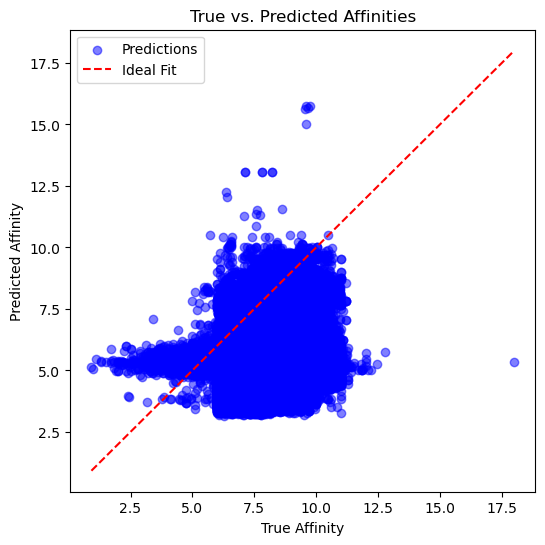

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the CSV file
df = pd.read_csv('predictions_pharos_full.csv')

# Extract true and predicted values
y_true = df['True Values'].values
y_pred = df['Predictions'].values

# Compute regression metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
pearson_corr, _ = stats.pearsonr(y_true, y_pred)
spearman_corr, _ = stats.spearmanr(y_true, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")
print(f"Pearson Correlation: {pearson_corr:.3f}")

# Scatter plot of true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle="--", label='Ideal Fit')  # Identity line
plt.xlabel("True Affinity")
plt.ylabel("Predicted Affinity")
plt.title("True vs. Predicted Affinities")
plt.legend()
plt.show()
